In [63]:
import contextlib
import ipynb.fs
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import torch
import wave

from collections import defaultdict
from scipy.io import wavfile
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn import tree
from tqdm import tqdm

from .defs.formant_vowel_prediction import vowel_prediction, vowel_prediction_sd
from .defs.vowel_feedback_function import vowel_feedback
from .defs.extract_formant import extract_formant

random_state=42
torch.manual_seed(random_state)

In [18]:
folder = '../../allwavs/allvowl/corrected/extracted'
files = os.listdir(folder)

In [19]:
# def trim_wav(in_wav, out_wav, start, end):
#     sample_rate, wave_data = wavfile.read(in_wav)
#     start_sample = int(start * sample_rate)
#     end_sample = int(end * sample_rate)
#     wavfile.write(out_wav, sample_rate, wave_data[start_sample:end_sample])
# 
# for file in tqdm(files):
#     if file == 'trimmed' or file == 'img':
#         continue
#     start, end = file.split('__')[2:4]
#     start = float(start)
#     end = float(end)
#     trim_wav(folder + '/' + file, folder + '/trimmed/' + file, start, end)

In [20]:
v_files = os.listdir(folder + '/trimmed')
cnt = 0
n_formants = 4

vowels = defaultdict(list)

for file in tqdm(v_files):
    if file == 'img':
        continue
    path = folder + '/trimmed/' + file
    with contextlib.closing(wave.open(path, 'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    try:
        formants = extract_formant(path, start_time=0, end_time=duration, f0min=math.ceil(3/duration + 0.000001), n_formants=n_formants)
        vowel, gender, start, end, phonemes, word, orig_file = file.split('__')
        vowel = vowel.replace('E+', 'e').replace('@', '2')
        if len(phonemes) == 1:
            phonemes = '_'.join(list(word.replace('1', ''))).replace('u', 'y')
        elif len(phonemes) == 2:
            phonemes = 't_E+'
        elif len(phonemes) == 3 and '_' not in phonemes:
            phonemes = 't_U~+'
        vowels[vowel].append([*formants, gender, phonemes.split('_')[0]])
        #print(vowel, gender, phonemes, word, *formants)
    except ZeroDivisionError:
        cnt += 1
        continue
        
print(cnt)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5577/5577 [01:01<00:00, 90.16it/s]

464


In [21]:
fs = [defaultdict(list) for i in range(n_formants)]
for key, val in vowels.items():
    for formants in val:
        for i in range(n_formants):
            fs[i][key].append(formants[i])

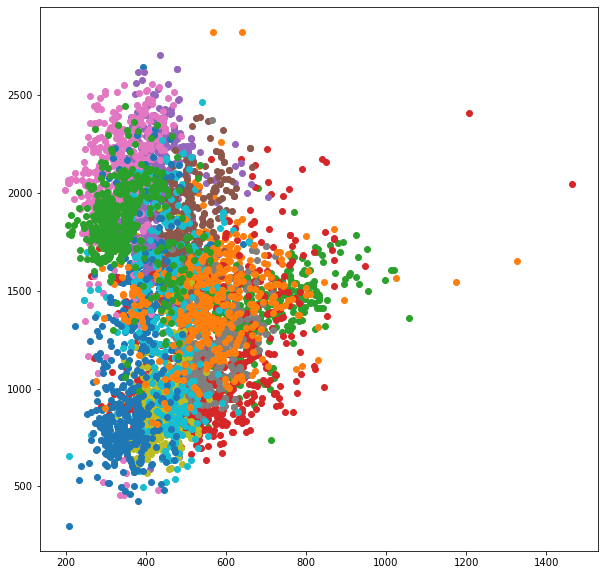

In [22]:
plt.figure(figsize=(10, 10))
for key in fs[0]:
    plt.scatter(fs[0][key], fs[1][key])
plt.show()

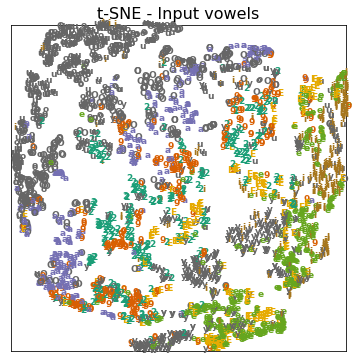

In [64]:
key2idx = {key: i for i, key in enumerate(vowels.keys())}
idx2key = {i: key for key, i in key2idx.items()}

include_nasals = False

def plot_tsne_embeddings(X, y, title):
    y = y.astype(int)
    X = QuantileTransformer(n_quantiles=len(X)).fit_transform(X)
    plt.figure(figsize = (6, 6))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 idx2key[y[i]],
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    return

len_dataset = sum(len(val) for val in vowels.values())
if not include_nasals:
    len_dataset -= sum(len(vowels[k]) for k in vowels.keys() if '~' in k)

formants_tot = torch.empty((len_dataset, n_formants + 7), dtype=torch.float)
labels_tot = torch.empty(len_dataset, dtype=torch.float)

i = 0
for key, val in vowels.items():
    if '~' in key and not include_nasals:
        continue
    for val2 in val:
        val2 = val2.copy()
        labels_tot[i] = key2idx[key]
        val2[n_formants] = int(val2[n_formants] == 'f')
        val2[n_formants + 1] = int(val2[n_formants + 1] == 'l')
        val2 += [0, 0, 0, 0, 0]
        val2[n_formants + 2] = int(val2[n_formants + 1] == 'm')
        val2[n_formants + 3] = int(val2[n_formants + 1] == 'p')
        val2[n_formants + 4] = int(val2[n_formants + 1] == 's')
        val2[n_formants + 5] = int(val2[n_formants + 1] == 't')
        val2[n_formants + 6] = int(val2[n_formants + 1] == 't1')
        formants_tot[i] = torch.FloatTensor(val2)
        i += 1

indices = torch.randperm(formants_tot.size()[0])
formants_tot = formants_tot[indices]
labels_tot = labels_tot[indices]
        
formants_tot = formants_tot.numpy()
labels_tot = labels_tot.numpy()

formants_TSNE = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(formants_tot)

plot_tsne_embeddings(formants_TSNE, labels_tot, 'Input vowels')

In [65]:
scaler = StandardScaler().fit(formants_tot[:, :n_formants])
formants_tot[:, :n_formants] = scaler.transform(formants_tot[:, :n_formants])

X_train, X_test, y_train, y_test = train_test_split(formants_tot, labels_tot, test_size=0.1, random_state=random_state)

feature_names = ['F' + str(i + 1) for i in range(n_formants)] + ['isF', 'm-', 'l-', 'p-', 's-', 't-', 't1-']
target_names = [idx2key[x] for x in [0, 1, 2, 4, 5, 6, 7, 8, 10, 12]]
classifiers = []

## Decision trees

              precision    recall  f1-score   support

           2     0.6552    0.7600    0.7037        25
           9     0.6486    0.7273    0.6857        33
           a     0.8800    0.7333    0.8000        30
           e     0.8936    0.7368    0.8077        57
           E     0.6154    0.6957    0.6531        23
           i     0.6304    0.7838    0.6988        37
           O     0.6486    0.6486    0.6486        37
           o     0.7500    0.7500    0.7500        40
           u     0.6750    0.5745    0.6207        47
           y     0.6667    0.7000    0.6829        40

    accuracy                         0.7073       369
   macro avg     0.7064    0.7110    0.7051       369
weighted avg     0.7181    0.7073    0.7090       369



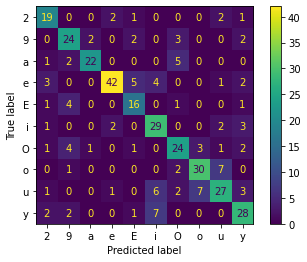

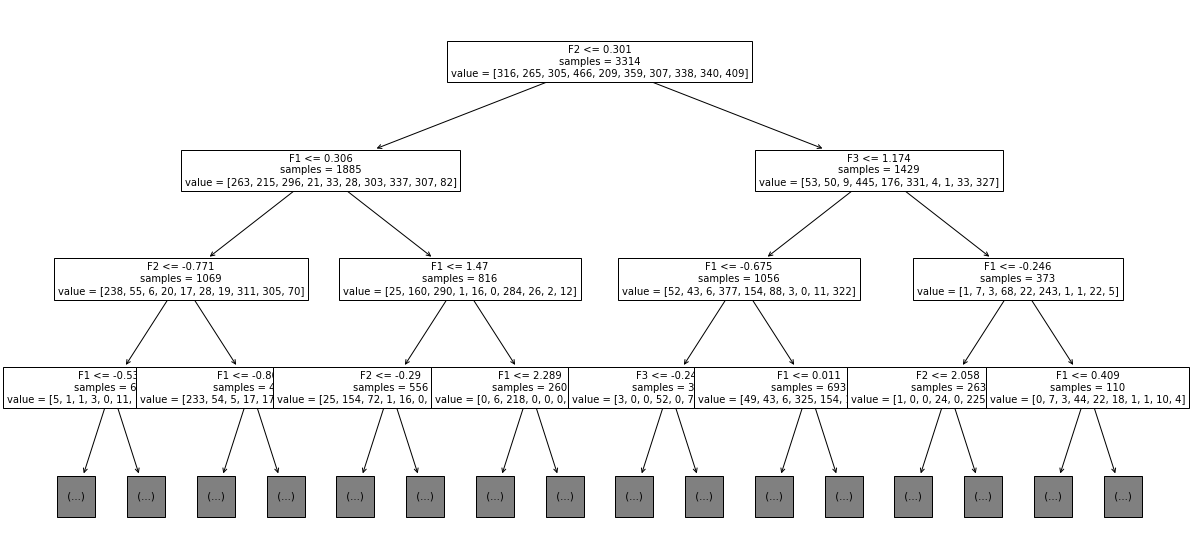

In [66]:
clf = tree.DecisionTreeClassifier(random_state=random_state)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
plt.show()
ax = plt.figure(figsize=(20, 10)).gca()
tree.plot_tree(clf, ax=ax, max_depth=3, fontsize=10, impurity=False, feature_names=feature_names)
classifiers.append(('DecisionTree', clf))
plt.show()

## Logistic Regression

              precision    recall  f1-score   support

           2     0.5769    0.6000    0.5882        25
           9     0.6364    0.6364    0.6364        33
           a     0.7500    0.8000    0.7742        30
           e     0.8095    0.8947    0.8500        57
           E     0.7273    0.6957    0.7111        23
           i     0.7250    0.7838    0.7532        37
           O     0.7368    0.7568    0.7467        37
           o     0.7742    0.6000    0.6761        40
           u     0.6875    0.7021    0.6947        47
           y     0.7778    0.7000    0.7368        40

    accuracy                         0.7290       369
   macro avg     0.7201    0.7169    0.7167       369
weighted avg     0.7297    0.7290    0.7274       369



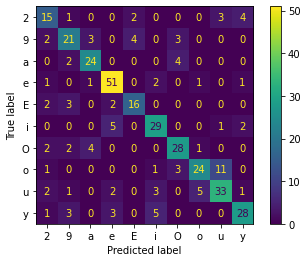

In [67]:
clf = LogisticRegression(random_state=random_state)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Logistic Regression', clf))
plt.show()

## K Neighbors

              precision    recall  f1-score   support

           2     0.5476    0.9200    0.6866        25
           9     0.6000    0.7273    0.6575        33
           a     0.8929    0.8333    0.8621        30
           e     0.8654    0.7895    0.8257        57
           E     0.6316    0.5217    0.5714        23
           i     0.7317    0.8108    0.7692        37
           O     0.8000    0.7568    0.7778        37
           o     0.7778    0.7000    0.7368        40
           u     0.7568    0.5957    0.6667        47
           y     0.8462    0.8250    0.8354        40

    accuracy                         0.7480       369
   macro avg     0.7450    0.7480    0.7389       369
weighted avg     0.7624    0.7480    0.7490       369



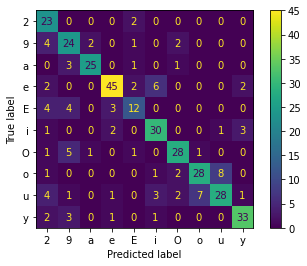

In [68]:
clf = KNeighborsClassifier(n_neighbors=3)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('K Neighbors', clf))
plt.show()

## Multilayer Perceptron

/home/anfasa/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           2     0.6667    0.8000    0.7273        25
           9     0.7059    0.7273    0.7164        33
           a     0.8182    0.9000    0.8571        30
           e     0.8600    0.7544    0.8037        57
           E     0.6129    0.8261    0.7037        23
           i     0.8378    0.8378    0.8378        37
           O     0.8529    0.7838    0.8169        37
           o     0.7879    0.6500    0.7123        40
           u     0.6875    0.7021    0.6947        47
           y     0.8462    0.8250    0.8354        40

    accuracy                         0.7724       369
   macro avg     0.7676    0.7806    0.7706       369
weighted avg     0.7801    0.7724    0.7732       369



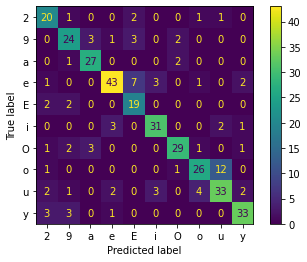

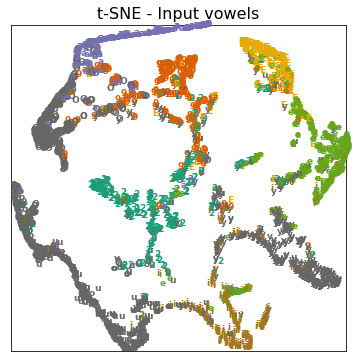

In [69]:
clf = MLPClassifier(random_state=random_state, hidden_layer_sizes=(25, 25), activation='tanh')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Multilayer Perceptron', clf))
plt.show()

activation = formants_tot
hidden_activation = ACTIVATIONS[clf.activation]
for i in range(clf.n_layers_ - 1):
    activation = np.dot(activation, clf.coefs_[i])
    activation += clf.intercepts_[i]
    if i != clf.n_layers_ - 2:
        hidden_activation(activation)
output_activation = ACTIVATIONS[clf.out_activation_]
output_activation(activation)

formants_TSNE = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(activation)
plot_tsne_embeddings(formants_TSNE, labels_tot, 'Input vowels')

## Random forests

              precision    recall  f1-score   support

           2     0.6562    0.8400    0.7368        25
           9     0.7742    0.7273    0.7500        33
           a     0.8333    0.8333    0.8333        30
           e     0.8654    0.7895    0.8257        57
           E     0.5938    0.8261    0.6909        23
           i     0.8108    0.8108    0.8108        37
           O     0.8056    0.7838    0.7945        37
           o     0.7561    0.7750    0.7654        40
           u     0.8000    0.6809    0.7356        47
           y     0.8684    0.8250    0.8462        40

    accuracy                         0.7832       369
   macro avg     0.7764    0.7892    0.7789       369
weighted avg     0.7922    0.7832    0.7847       369



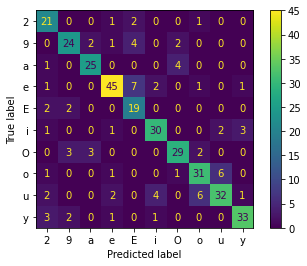

In [70]:
clf = RandomForestClassifier(random_state=random_state, n_estimators=100)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Random forest', clf))
plt.show()

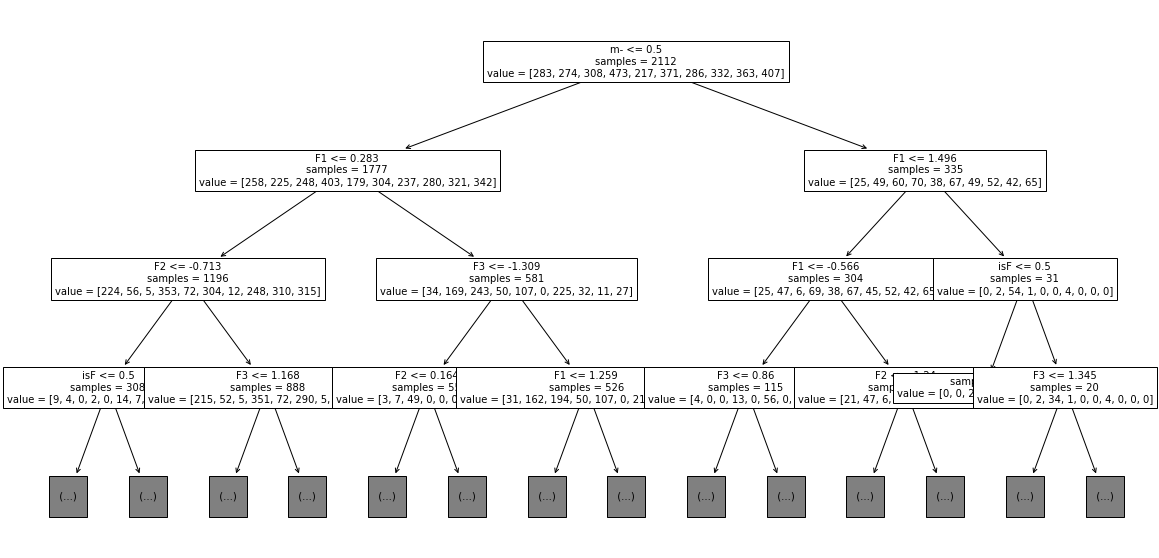

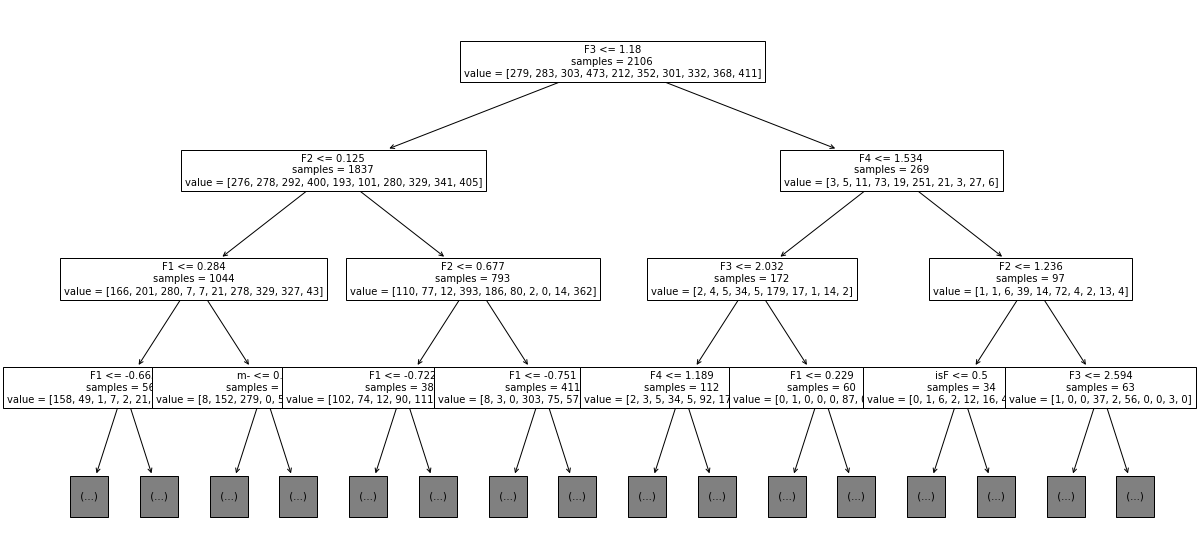

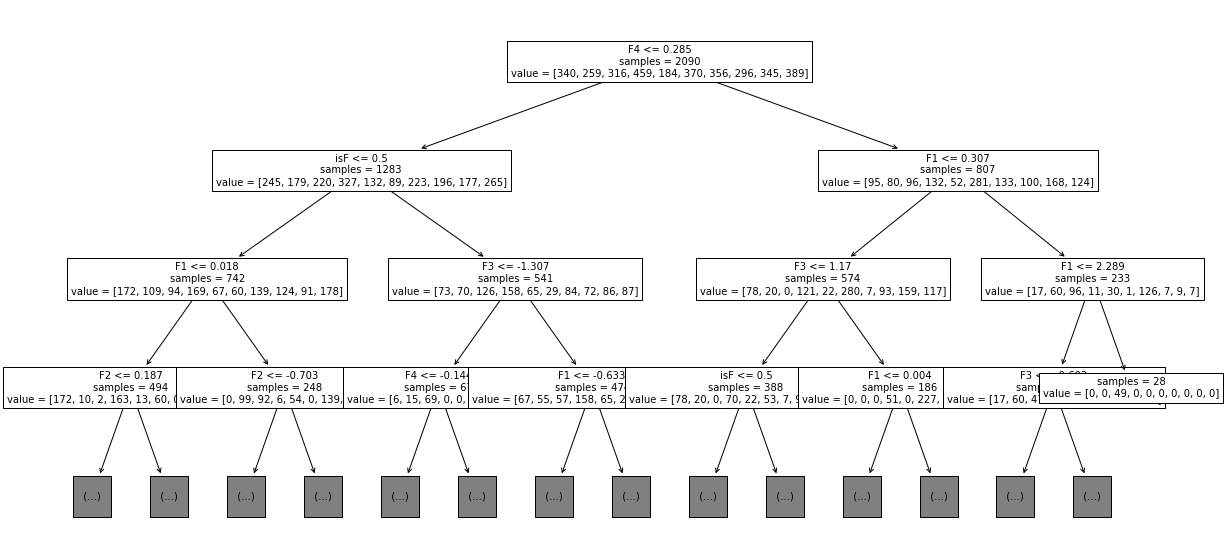

In [43]:
for estimator in clf.estimators_[:3]:
    ax = plt.figure(figsize=(20, 10)).gca()
    tree.plot_tree(estimator, ax=ax, max_depth=3, fontsize=10, impurity=False, feature_names=feature_names)
    plt.show()

## Bagging

              precision    recall  f1-score   support

           2     0.7188    0.9200    0.8070        25
           9     0.8065    0.7576    0.7812        33
           a     0.8621    0.8333    0.8475        30
           e     0.8431    0.7544    0.7963        57
           E     0.6000    0.7826    0.6792        23
           i     0.7714    0.7297    0.7500        37
           O     0.8182    0.7297    0.7714        37
           o     0.7632    0.7250    0.7436        40
           u     0.7500    0.7021    0.7253        47
           y     0.7609    0.8750    0.8140        40

    accuracy                         0.7724       369
   macro avg     0.7694    0.7809    0.7716       369
weighted avg     0.7787    0.7724    0.7726       369



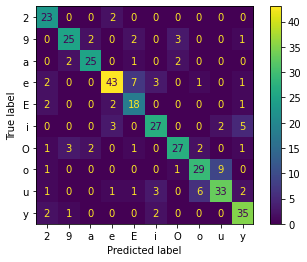

In [71]:
clf = BaggingClassifier(random_state=random_state, n_estimators=10)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Bagging', clf))
plt.show()

## Extra trees

              precision    recall  f1-score   support

           2     0.7586    0.8800    0.8148        25
           9     0.7742    0.7273    0.7500        33
           a     0.8387    0.8667    0.8525        30
           e     0.8776    0.7544    0.8113        57
           E     0.6207    0.7826    0.6923        23
           i     0.7561    0.8378    0.7949        37
           O     0.8333    0.8108    0.8219        37
           o     0.7561    0.7750    0.7654        40
           u     0.8000    0.6809    0.7356        47
           y     0.8333    0.8750    0.8537        40

    accuracy                         0.7913       369
   macro avg     0.7849    0.7990    0.7892       369
weighted avg     0.7966    0.7913    0.7914       369



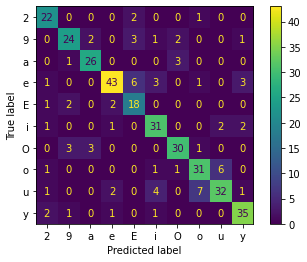

In [72]:
clf = ExtraTreesClassifier(random_state=random_state, n_estimators=500)
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
classifiers.append(('Extra trees', clf))
plt.show()

## Stacking

              precision    recall  f1-score   support

           2     0.7097    0.8800    0.7857        25
           9     0.7879    0.7879    0.7879        33
           a     0.8966    0.8667    0.8814        30
           e     0.8980    0.7719    0.8302        57
           E     0.7308    0.8261    0.7755        23
           i     0.7838    0.7838    0.7838        37
           O     0.8000    0.7568    0.7778        37
           o     0.7500    0.7500    0.7500        40
           u     0.7209    0.6596    0.6889        47
           y     0.7174    0.8250    0.7674        40

    accuracy                         0.7805       369
   macro avg     0.7795    0.7908    0.7829       369
weighted avg     0.7854    0.7805    0.7807       369



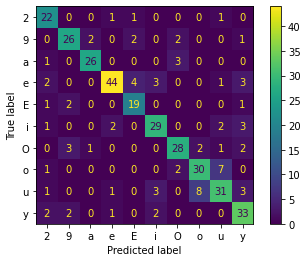

In [73]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(classifiers, cv='prefit')
clf = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx2key[x] for x in clf.classes_])
disp.plot()
plt.show()

In [202]:
clf = classifiers[-1][1]
from joblib import dump
dump(clf, '../models/rule_based.joblib')
dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']

In [208]:
np.where((X_test[0] == formants_tot).all(axis=1))

(array([2023]),)

In [209]:
formants_tot[2023]

array([ 0.00612146, -1.2264178 , -0.11720657,  0.37842092,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [224]:
for key, val in vowels.items():
    if '~' in key and not include_nasals:
        continue
    for i, val2 in enumerate(val):
        val3 = scaler.transform(np.array(val2[:4]).reshape(1, -1))[0]
        if 0.0060 < val3[0] < 0.0062:
            print(key, i)
            save_key = key
            save_i = i
j = 0
for file in v_files:
    if file.startswith(save_key):
        j += 1
    if save_i == j:
        print(file)
        break

o 134
o__f__0.14000__0.22000__m_o__mot__hzc1_mono.wav
